In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import Tuple, Optional
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.manifold import TSNE
import shap
import seaborn as sns
sys.path.append("../code")
from config import DL_MODELS, DL_MODELS_IMAGE_BASED
from dataloader import dataset, data_loader
from hparams_tuner.dl_models_tuner import DLModelTuner
from evaluate_model import Model_Evaluation
from tabmap_construction import TabMapGenerator

### Load example dataset BCTIL
Dataset source: [Single-cell profiling of breast cancer T cells reveals a tissue-resident memory subset associated with improved prognosis](https://www.nature.com/articles/s41591-018-0078-7)

In [2]:
data_path='../data'
data_set='bctil'

# Define paths and ensure directory existence
data_dir = os.path.join(data_path, data_set)
os.makedirs(os.path.dirname(data_dir), exist_ok=True)

# Load the dataset
features, labels, feature_names = dataset.load_data(data_dir, scaler_name='minmax', preprocessed=False)
n_classes = len(np.unique(labels))

# Define paths to save classification results
results_path = f'../results/{data_set}'

Performing data preprocessing...
Discarded features: ['VWA1', 'NPPA-AS1', 'HSPG2', 'OLFML3', 'CD1E', 'RAB7B', 'CTD-2090I13.1', 'CXCL9', 'RP11-286E11.1', 'CFI', 'MAP1B', 'BMP6', 'GJA1', 'VGF', 'COL15A1', 'BACE1', 'A2M', 'COL4A1', 'CCL8', 'C19orf35']
CD4+ CXCL13+ -> 0
CD4+ FOXP3+ -> 1
CD4+ IL7R+ -> 2
CD4+ RGCC+ -> 3
CD4+ TRM -> 4
CD8+ TEM -> 5
CD8+ TRM -> 6
CD8+ mitotic TRM -> 7
CD8+ Î³Î´ -> 8
Monocyte -> 9


In [3]:
# Define label mapping
label_mapping = {
    0: r"CD4$^{+}$ CXCL13$^{+}$",
    1: r"CD4$^{+}$ FOXP3$^{+}$",
    2: r"CD4$^{+}$ IL-7R$^{+}$",
    3: r"CD4$^{+}$ RGCC$^{+}$",
    4: r"CD4$^{+}$ T$_{RM}$",
    5: r"CD8$^{+}$ T$_{EM}$",
    6: r"CD8$^{+}$ T$_{RM}$",
    7: r"CD8$^{+}$ T$_{RM}$ mitotic",
    8: r"CD8$^{+}$ $\gamma \delta$",
    9: "Monocyte"
}

### Generate TabMaps from data and train a 2D CNN classifier on TabMaps

In [4]:
def generate_images(model_id: str, 
                    features: np.ndarray, 
                    train_idx: list, 
                    test_idx: list,
                    save_path: Optional[str]=None, 
                    save_images: bool=True) -> Tuple[np.ndarray, float]:
    print(f"Generating images for {model_id}")
    
    if model_id not in DL_MODELS_IMAGE_BASED:
        raise ValueError(f"Unsupported model_id: {model_id}")
    
    if model_id == 'TabMap':
        generator = TabMapGenerator(metric='euclidean', loss_fun='kl_loss')
        generator.fit(features[train_idx])
        X_train_img = generator.transform(features[train_idx])
        X_test_img = generator.transform(features[test_idx])
    
    images = np.empty((len(features), X_train_img.shape[1], X_train_img.shape[2]))
    images[train_idx] = X_train_img
    images[test_idx] = X_test_img
    
    if save_images and save_path:
        np.save(save_path, images) 
        print(f"Images saved to {save_path}")
    
    return images, generator

In [5]:
seed = 0
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# set seed
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

predictions_test_df = pd.DataFrame()
performance_test_df = pd.DataFrame()

skf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=seed)
for fold_id, (train_idx_all, test_idx) in enumerate(skf.split(features, labels)):
    
    train_idx, valid_idx = train_test_split(train_idx_all, test_size=0.125,
                                            random_state=seed,
                                            stratify=labels[train_idx_all])

    images_dict = {}
    for model_id in ['TabMap']:
        print(f"\nTraining {model_id}...")
        images_save_path = os.path.join(data_dir, f"{model_id}.npy")
        images, generator = generate_images(model_id, features, train_idx_all, test_idx, 
                                            save_path=images_save_path)
        
        data_config = {
            "data_set": data_set,
            "data_dir": data_dir,
            "n_classes": n_classes,
            "input_size": images.shape[1:],
            "fold_id": fold_id,
        }
    
        tuner = DLModelTuner(data_config, train_idx, valid_idx, model_id, 
                            results_path, 
                            use_default_hparams=True,
                            random_seed=seed)
        
        best_params_dict = tuner.params_dict
        best_params_dict['fold'] = fold_id
        
        # Model evaluation on the best trained model
        model_eval = Model_Evaluation(model_id)
        _, y_pred = model_eval.model_predict(tuner.final_model, features=images[test_idx])

        performance_test = model_eval.prediction_performance(labels[test_idx].ravel(), y_pred.ravel())
        performance_test = pd.DataFrame([performance_test])
        performance_test["fold"] = fold_id
        performance_test_df = pd.concat([performance_test_df, performance_test])
    
    print(f'\n', performance_test_df)


Training TabMap...
Generating images for TabMap
Solving optimization problem...
Images saved to ../data/bctil/TabMap.npy
Epoch 13/30: Train Loss: 0.0000, Val Loss: 0.0193, Val Acc: 0.7771
Early stopping triggered

     model     BA      F1     MCC  fold
0  TabMap  0.819  0.8315  0.7987     0


### Feature importance analysis for biomarker identification

In [6]:
background = torch.from_numpy(np.expand_dims(images[train_idx], axis=1)).float()[:1000].to(device)
test_images = torch.from_numpy(np.expand_dims(images[test_idx], axis=1)).float().to(device)
explainer = shap.DeepExplainer(tuner.final_model, background)
shap_values = explainer.shap_values(test_images)

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


In [7]:
# Load projection matrix
projMap = generator.project_matrix
print(projMap.shape)

order_mapping = {} #key: feature index in original data, value: pixel index in genomap flatten vector
for i, col_id in enumerate(range(projMap.shape[1])):
    org_idx = int(np.nonzero(projMap[:, col_id])[0][0])
    order_mapping[org_idx] = i
    
all_indices = list(range(images[0].flatten().shape[0]))
indices_keep = all_indices[:len(order_mapping)]

from collections import defaultdict
tabmap_shap = defaultdict(list)
for i, class_id in enumerate(list(set(y_pred))):
    for shap_value in shap_values[i]:
        shap_dim = shap_value.shape
        shap_value_flattened = shap_value.flatten()
        shap_value_flattened = shap_value_flattened[indices_keep]
        shap_value_reordered = [shap_value_flattened[idx] for idx in dict(sorted(order_mapping.items())).values()]
        tabmap_shap[class_id].append(shap_value_reordered)
        
tabmap_shap = {class_id: np.stack(shap_value) for class_id, shap_value in tabmap_shap.items()}

(15603, 15603)


In [8]:
feature_importances_list = []
feature_importances_norm_list = []
for i, class_id in enumerate(list(set(y_pred))):
    importances = []
    for k in range(tabmap_shap[class_id].shape[1]):
        importances.append(np.mean(np.abs(tabmap_shap[class_id][:,k])))
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, feature_names)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_list.append(feature_importances)

In [14]:
biomarkers = {
    0: ['IGFL2', 'GNG4', 'NR3C1', 'CHN1', 'CD200', 'ITM2A', 'CPM'], 
    1: ['TNFRSF4', 'RTKN2', 'IL2RA', 'BATF', 'FOXP3', 'PIM2', 'TNFRSF18', 'CTLA4'], 
    2: ['IL7R', 'JUN', 'CD69', 'CD40LG', 'DUSP1', 'PLAC8', 'FOS'], 
    3: ['RGCC', 'CXCR4', 'YPEL5', 'ZFP36', 'LMNA', 'CREM', 'ANXA1', 'ZNF331'], 
    4: ['ALOX5AP', 'IFNG', 'PDCD1', 'ANKRD28', 'IL26', 'DAPK2', 'CKLF'], 
    5: ['KLRG1', 'TXNIP', 'LYAR', 'CD8B', 'GZMK', 'FCRL6', 'GZMM'], 
    6: ['HAVCR2', 'KLRC1', 'GZMB', 'CCL4', 'VCAM1', 'LAG3', 'PRF1', 'CCL3'], 
    7: ['HMGB2', 'CKS1B', 'TUBA1B', 'STMN1', 'TUBB', 'CCNA2', 'H2AFZ'], 
    8: ['TRGC2', 'IFITM3', 'ZNF683', 'NUCB2', 'XCL1', 'CTSW', 'XCL2', 'NCR3'], 
    9: ['FTL', 'CST3', 'FTH1', 'PSAP', 'CSTB', 'SOD2', 'NPC2']
}

In [10]:
def find_sublist_index(original_list, sublist):
    sublist_length = len(sublist)
    for i in range(len(original_list) - sublist_length + 1):
        if original_list[i:i + sublist_length] == sublist:
            return i
    return -1

biomarkers_list = [item for sublist in biomarkers.values() for item in sublist]
indexes = [list(feature_names).index(item) for item in biomarkers_list if item in list(feature_names)]

shap_plot = []
for class_label in list(label_mapping.keys()):
    indices_for_class = [i for i, label in enumerate(labels[test_idx]) if label == class_label]
    if len(indices_for_class) > 50:
        sampled_indices = np.random.choice(indices_for_class, size=50, replace=False)
    else:
        sampled_indices = indices_for_class
    
    for i in sampled_indices:
        shap_plot.append(tabmap_shap[class_label][i][indexes])

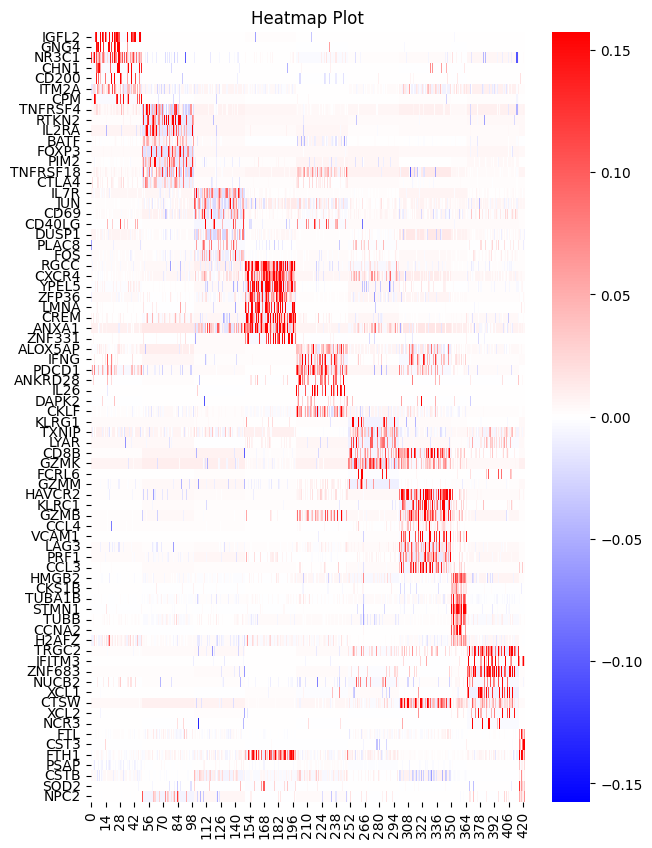

In [11]:
shap_plot = np.array(shap_plot)
vmin, vmax = np.nanpercentile(shap_plot.flatten(), [1, 99])

plt.figure(figsize=(7, 10))
sns.heatmap(
    shap_plot.T,
    vmin=min(vmin,-vmax),
    vmax=max(-vmin,vmax),
    cmap='bwr', 
    yticklabels=biomarkers_list
)
plt.title('Heatmap Plot')
plt.show()

### Visualize the embeddings extracted from the trained TabMap-based model

In [12]:
# Extract features from the trained model
dataloader_all= torch.utils.data.DataLoader(
        dataset=data_loader.TabularDataset(images, labels),
        batch_size=len(labels),
        shuffle=False,
        drop_last=False
    )

features = []
tuner.final_model.to(device)
tuner.final_model.eval()

with torch.no_grad():
    for inputs, _ in dataloader_all:
        inputs = inputs.unsqueeze(1) if inputs.dim() == 3 else inputs
        inputs = inputs.to(device)
        feature_output = tuner.final_model(inputs.float(), features=True)
        features.append(feature_output)

features = torch.cat(features, 0)

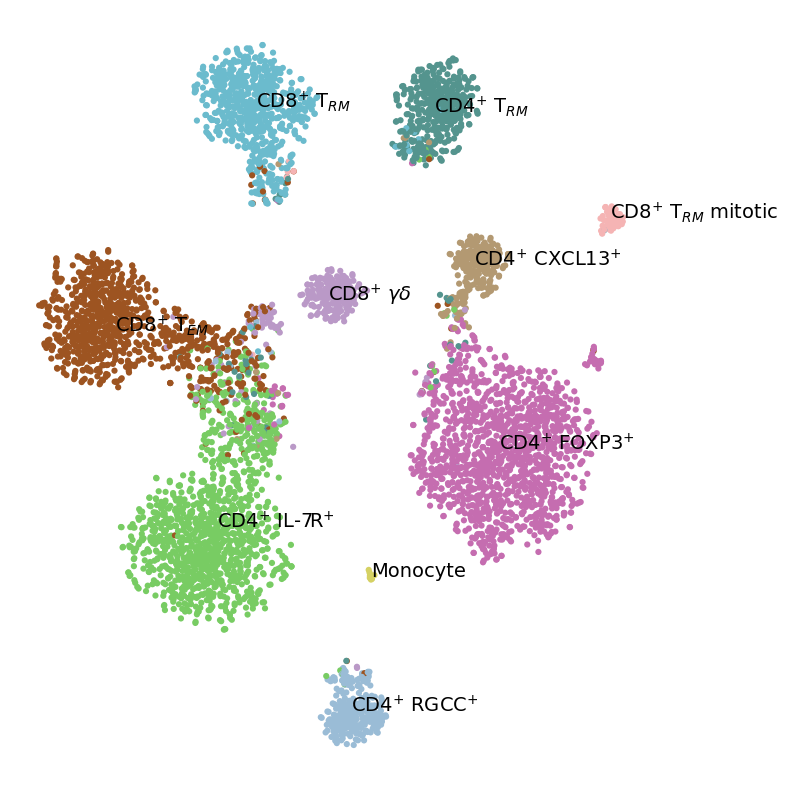

In [13]:
# Compute t-SNE embeddings
embeddings = TSNE(random_state=seed).fit_transform(features.cpu().numpy())

# Define color palette
palette = np.array([
    '#B39972', '#C56DB0', '#78CC63', '#9ABCD6', '#54948E',
    '#9D5421', '#6BBBCD', '#F5B4B4', '#BA99C7', '#D5D163'
])

f = plt.figure(figsize=(8, 8))
plt.scatter(embeddings[:,0], embeddings[:,1], lw=0, s=20, c=palette[labels])
plt.ylabel('t-SNE2', fontsize=16)
plt.xlabel('t-SNE1', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Add the labels for each class
txts = []
for i in range(10):
    xtext, ytext = np.median(embeddings[labels == i, :], axis=0)
    txt = plt.text(xtext, ytext, label_mapping[i], fontsize=14)
    txts.append(txt)

plt.axis('off')
plt.tight_layout()